# Reference

https://deep-learning-study.tistory.com/459

In [1]:
from os import listdir
from os.path import join
import os.path

from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchsummary import summary

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

import random

In [2]:
import gdown
import patoolib

url       = 'https://drive.google.com/uc?id='
file_id   = '1iVt97n4fpFKUeTW93kNGMzbadRbHCjUf'
data_path = '../data/'
data_dir  = 'extracted_images'
data_file = 'math_data.rar'

if os.path.isdir(data_path+data_dir):
    print('already exist')

elif not os.path.isfile(data_path+data_file):
    gdown.download(url + file_id, data_path+data_file, quiet=False)
    patoolib.extract_archive(data_path+data_file, outdir='../data/')
    
else:
    patoolib.extract_archive(data_path+data_file, outdir='../data/')


already exist


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'using {device}')

random.seed(777)
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

training_epochs = 15
batch_size = 50

using cuda


In [4]:
print("")
label = {}
num = 0
for className in listdir(join(data_path, "extracted_images")) :
  print(f"{className}:{len(listdir(join(data_path, 'extracted_images', className)))}")
  label[className] = num
  num += 1


v:1558
,:1906
beta:2025
cos:2986
4:7396
forward_slash:199
prime:329
G:1692
mu:177
ascii_124:1339
{:376
Delta:137
7:2909
sin:4293
forall:45
):14355
lim:1675
lambda:109
9:3737
k:3074
pi:2332
}:377
z:5870
geq:693
A:12367
(:14294
i:5140
p:2680
f:3712
o:449
5:3545
tan:2450
T:3274
j:1536
l:1017
phi:355
C:5802
y:9340
neq:558
R:2671
]:780
M:2476
8:3068
e:3003
sum:2689
0:6914
q:1230
b:8651
!:1300
u:1269
=:13104
leq:973
div:868
-:33997
sqrt:8908
rightarrow:1703
2:26141
w:556
gamma:409
ldots:609
pm:802
X:26594
infty:1783
exists:21
lt:477
1:26520
d:4852
N:10862
gt:258
theta:2796
sigma:201
6:3118
+:25112
[:778
times:3251
log:2001
in:47
int:2742
alpha:2546
3:10909
H:1464
S:1413


In [21]:
trans = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor() 
    ])
trainset = torchvision.datasets.ImageFolder(root = data_path + 'extracted_images',
                                            transform = trans)
classes = trainset.classes
len(trainset.classes)

82

In [6]:
train_size = int(0.9 * len(trainset))
test_size = len(trainset) - train_size

train_data, test_data = torch.utils.data.random_split(trainset, [train_size, test_size])

train_loader = DataLoader(train_data,
                         batch_size = batch_size,
                         shuffle = True,
                         drop_last = True)

test_loader = DataLoader(test_data,
                         batch_size = batch_size,
                         shuffle = False,
                         drop_last = True)

print(f'train size = {train_size}\ntest size = {test_size}')
print('')
print(f'training data set = {len(train_loader)}\ntest data set = {len(test_loader)}')

train size = 338376
test size = 37598

training data set = 6767
test data set = 751


In [13]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 4, 1) # input, output, kernel_size, stride
        self.conv2 = nn.Conv2d(20, 50, 4, 1)
        self.fc1 = nn.Linear(9*9*50, 500)
        self.fc2 = nn.Linear(500, 82)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 9*9*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [14]:
model = Net()
model.to(device)
summary(model, input_size=(1, 45, 45))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 20, 42, 42]             340
            Conv2d-2           [-1, 50, 18, 18]          16,050
            Linear-3                  [-1, 500]       2,025,500
            Linear-4                   [-1, 82]          41,082
Total params: 2,082,972
Trainable params: 2,082,972
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.40
Params size (MB): 7.95
Estimated Total Size (MB): 8.35
----------------------------------------------------------------


In [15]:
# define the negative log-likelihood loss
loss_func = nn.NLLLoss(reduction='sum')

# define the Adam optimizer
opt = optim.Adam(model.parameters(), lr=1e-4)


In [16]:
# define a helper function to compute the loss value per mini-batch
def loss_batch(loss_func, xb, yb, yb_h, opt=None):
    # obtain loss
    loss = loss_func(yb_h, yb)
    # obtain performance metric
    metric_b = metrics_batch(yb, yb_h)
    if opt is not None:
        loss.backward() # compute gradient
        opt.step() # update parameters
        opt.zero_grad() # set gradients to zero
    return loss.item(), metric_b
    
# define a helper function to compute the accurary per mini-batch
def metrics_batch(target, output):
    # optain output class
    pred = output.argmax(dim=1, keepdim=True)
    # compare output class with target class
    corrects = pred.eq(target.view_as(pred)).sum().item()
    
    return corrects
    
# define a helper fuction to compute the loss and metric values for a dataset
def loss_epoch(model, loss_func, dataset_dl, opt=None):
    loss = 0.0
    metric = 0.0
    len_data = len(dataset_dl.dataset)
    
    for xb, yb in dataset_dl:
        xb = xb.type(torch.float).to(device)
        yb = yb.to(device)
        # obtain model output
        yb_h = model(xb)
        
        loss_b, metric_b = loss_batch(loss_func, xb, yb, yb_h, opt)
        loss += loss_b
        if metric_b is not None:
            metric += metric_b
            
    loss /= len_data
    metric /= len_data
    return loss, metric

In [17]:
# define train_val function
def train_val(epochs, model, loss_func, opt, train_dl, val_dl):
    for epoch in range(epochs):
        model.train() # convert to train mode
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, opt)
        model.eval() # convert to evaluation mode
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl)
        accuracy = 100 * val_metric
        print('epoch: %d, train loss: %.6f, val loss: %.6f, accuracy: %.2f' %(epoch, train_loss, val_loss, accuracy))

In [19]:
train_val(training_epochs, model, loss_func, opt, train_loader, test_loader)

epoch: 0, train loss: 0.811392, val loss: 0.386079, accuracy: 88.87
epoch: 1, train loss: 0.304112, val loss: 0.251529, accuracy: 92.61
epoch: 2, train loss: 0.209624, val loss: 0.185297, accuracy: 94.45
epoch: 3, train loss: 0.158766, val loss: 0.145170, accuracy: 95.38
epoch: 4, train loss: 0.124332, val loss: 0.126962, accuracy: 96.01


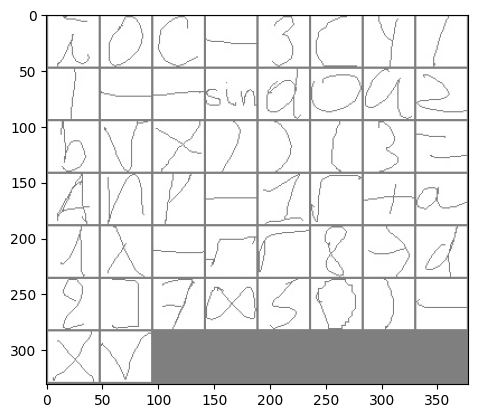

i     0     C     -     3     C     y     1     1     -     -     sin   A     0     A     2     b     v     X     )     )     (     3     =     A     N     R     -     1     sqrt  +     A     1     lambda -     sqrt  R     8     rightarrow d     2     ]     7     infty 5     0     )     -     times v    


In [22]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(train_loader)
images, labels = next(dataiter)

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

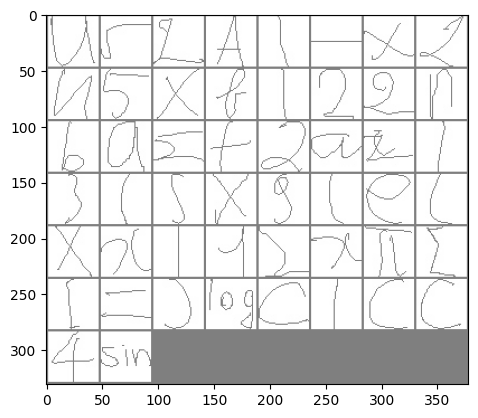

GroundTruth:  u     sqrt  2     A    


In [25]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

# 이미지를 출력합니다.
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [29]:
correct = 0
total = 0
model.to(device)
model.eval()
# 학습 중이 아니므로, 출력에 대한 변화도를 계산할 필요가 없습니다
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        # 신경망에 이미지를 통과시켜 출력을 계산합니다
        outputs = model(images)
        # 가장 높은 값(energy)를 갖는 분류(class)를 정답으로 선택하겠습니다
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor